In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import rgb2hex
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE
from imblearn.pipeline import make_pipeline

In [2]:
postural_labels = ['STAND_TO_LIE', 'SIT_TO_LIE', 'LIE_TO_SIT', 'LIE_TO_STAND', 'STAND_TO_SIT', 'SIT_TO_STAND']

df = pd.read_csv('dataset.csv')
df = df.loc[df['Activity'].isin(postural_labels)]

X = df.drop(columns=['Activity'])
y = df['Activity']

dcopy = df.copy()
dcopy['Activity'] = [
    1 if a == 'STAND_TO_SIT'
    else 2 if a == 'SIT_TO_STAND'
    else 3 if a == 'SIT_TO_LIE'
    else 4 if a == 'LIE_TO_SIT'
    else 5 if a == 'STAND_TO_LIE'
    else 6
    for a in dcopy['Activity']
]

metrics = ['f1_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'accuracy']

## Distribuição de classes

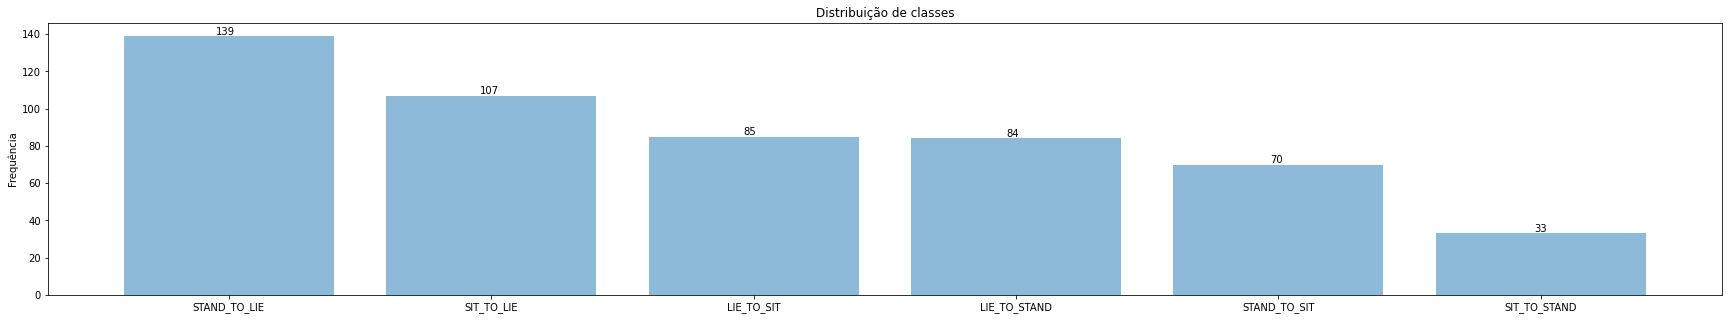

In [3]:
counts = y.value_counts()
bar_y = counts.index.to_list()
bar_x = counts.tolist()
y_pos = np.arange(len(bar_y))

plt.subplots(figsize=(30,5))
plt.bar(y_pos, bar_x, align='center', alpha = 0.5)
plt.xticks(y_pos, bar_y)
xlocs, xlabs = plt.xticks()
plt.ylabel('Frequência')
plt.title('Distribuição de classes')
for i, v in enumerate(bar_x):
    plt.text(xlocs[i] - 0.05 + i*0.005, v + 0.7, str(v))

## Scatter plot

In [4]:
# Pre-Process data

tsne_data = X.copy()
label = y.copy()

# Scale data so it has mean = 0, std = 1
scl = StandardScaler()
# and scale every entry to [0,1] range
tsne_data = scl.fit_transform(tsne_data)
# so that the sparse data is centered

# Reduce dimensions (speed up)
# uses SVD (Singular Value Decomposition)
# to linear dimensionality reduction (projection)
# requires not sparsed data
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
# t-distributed stochastic neighbor embedding
# nonlinear dimensionality reduction to high dim data
# for visulation on low dim spaces
tsne = TSNE(random_state=42, n_jobs=-1)
tsne_transformed = tsne.fit_transform(tsne_data)


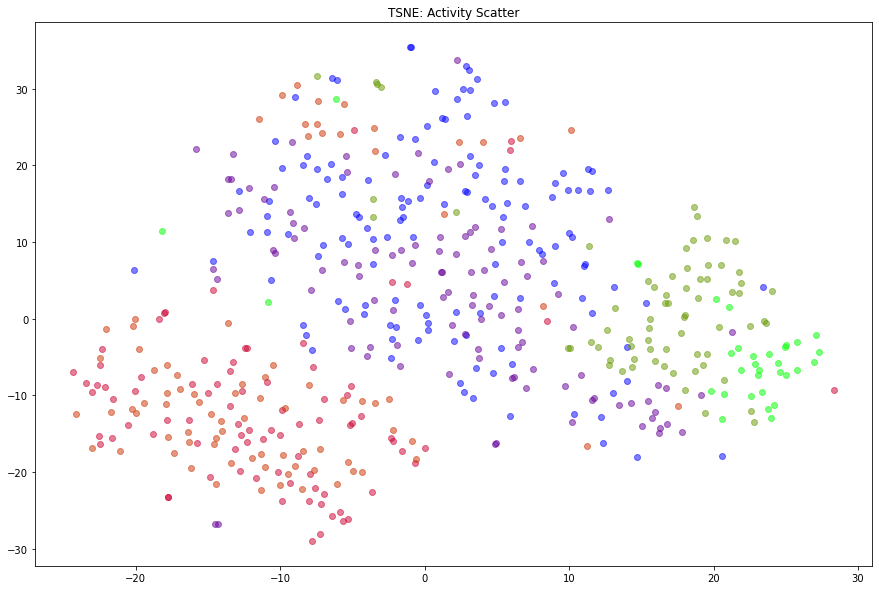

In [5]:
## Plot Activities

# Create subplots
plt.subplots(figsize=(15,10))

# Get colors
n = label.unique().shape[0]
colormap = get_cmap('brg')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(label.value_counts().index):
    # Mask to separate sets
    mask = (label==group).values
    # ax[0]
    plt.scatter(
        x=tsne_transformed[mask][:,0],
        y=tsne_transformed[mask][:,1],
        c=colors[i],
        alpha=0.5,
        label=group
    )
plt.title('TSNE: Activity Scatter')
plt.show()

## KNN

In [6]:
knn_results = []

# KNN classifiers with odd K in range of (1,19)
# search for best K
for i in range(10):
    k = i*2+1
    knnClass = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    result = cross_validate(knnClass, X, y, cv=10, scoring=metrics,
                            return_train_score=True, n_jobs=-1)
    knn_results.append(result)
    print("k = " + str(k) + ":")

    print("\tf1:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_f1_weighted').mean()*100,
                std = result.get('test_f1_weighted').std()))

    print("\tROC AUC OneVsRest:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovr_weighted').mean()*100,
                std = result.get('test_roc_auc_ovr_weighted').std()))

    print("\tROC AUC OneVsOne:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovo_weighted').mean()*100,
                std = result.get('test_roc_auc_ovo_weighted').std()))

    print("\tbalanced accuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_balanced_accuracy').mean()*100,
                std = result.get('test_balanced_accuracy').std()))

    print("\taccuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
          .format(mean = result.get('test_accuracy').mean()*100,
                  std = result.get('test_accuracy').std()))

# spoiler it's: 9

k = 1:
	f1:
		mean = 71.81%;
		std = 0.07;
	ROC AUC OneVsRest:
		mean = 82.90%;
		std = 0.04;
	ROC AUC OneVsOne:
		mean = 84.31%;
		std = 0.03;
	balanced accuracy:
		mean = 75.29%;
		std = 0.05;
	accuracy:
		mean = 72.58%;
		std = 0.07;
k = 3:
	f1:
		mean = 72.92%;
		std = 0.05;
	ROC AUC OneVsRest:
		mean = 91.81%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 92.94%;
		std = 0.02;
	balanced accuracy:
		mean = 76.71%;
		std = 0.04;
	accuracy:
		mean = 73.75%;
		std = 0.05;
k = 5:
	f1:
		mean = 72.28%;
		std = 0.03;
	ROC AUC OneVsRest:
		mean = 93.99%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 94.90%;
		std = 0.01;
	balanced accuracy:
		mean = 76.04%;
		std = 0.03;
	accuracy:
		mean = 72.99%;
		std = 0.03;
k = 7:
	f1:
		mean = 73.68%;
		std = 0.02;
	ROC AUC OneVsRest:
		mean = 94.54%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 95.42%;
		std = 0.01;
	balanced accuracy:
		mean = 77.43%;
		std = 0.02;
	accuracy:
		mean = 74.72%;
		std = 0.02;
k = 9:
	f1:
		mean = 74.03%;
		std = 0.03;
	ROC AUC 

## KNN report

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=42)
knn = KNeighborsClassifier(n_neighbors=9, n_jobs=-1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

  LIE_TO_SIT       0.61      0.85      0.71        26
LIE_TO_STAND       0.75      0.36      0.49        25
  SIT_TO_LIE       0.71      0.75      0.73        32
SIT_TO_STAND       0.80      0.80      0.80        10
STAND_TO_LIE       0.79      0.79      0.79        42
STAND_TO_SIT       0.82      0.86      0.84        21

    accuracy                           0.73       156
   macro avg       0.75      0.73      0.72       156
weighted avg       0.74      0.73      0.72       156



## Decision Tree

In [8]:
tree_results = []

# Search for the best tree depth
for i in range(1, 17):
    curr = DecisionTreeClassifier(random_state=42, max_depth=i)
    result = cross_validate(curr, X, y, cv=10, scoring=metrics,
                            return_train_score=True, n_jobs=-1)
    tree_results.append(result)
    print("Depth = " + str(i) + ":")

    print("\tf1:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_f1_weighted').mean()*100,
                std = result.get('test_f1_weighted').std()))

    print("\tROC AUC OneVsRest:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovr_weighted').mean()*100,
                std = result.get('test_roc_auc_ovr_weighted').std()))

    print("\tROC AUC OneVsOne:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovo_weighted').mean()*100,
                std = result.get('test_roc_auc_ovo_weighted').std()))

    print("\tbalanced accuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_balanced_accuracy').mean()*100,
                std = result.get('test_balanced_accuracy').std()))

    print("\taccuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
          .format(mean = result.get('test_accuracy').mean()*100,
                  std = result.get('test_accuracy').std()))

# spoiler it's 9

Depth = 1:
	f1:
		mean = 26.08%;
		std = 0.01;
	ROC AUC OneVsRest:
		mean = 75.77%;
		std = 0.01;
	ROC AUC OneVsOne:
		mean = 75.07%;
		std = 0.01;
	balanced accuracy:
		mean = 33.01%;
		std = 0.01;
	accuracy:
		mean = 42.86%;
		std = 0.01;
Depth = 2:
	f1:
		mean = 48.14%;
		std = 0.06;
	ROC AUC OneVsRest:
		mean = 84.30%;
		std = 0.03;
	ROC AUC OneVsOne:
		mean = 83.07%;
		std = 0.03;
	balanced accuracy:
		mean = 44.87%;
		std = 0.04;
	accuracy:
		mean = 55.57%;
		std = 0.05;
Depth = 3:
	f1:
		mean = 61.53%;
		std = 0.07;
	ROC AUC OneVsRest:
		mean = 89.54%;
		std = 0.03;
	ROC AUC OneVsOne:
		mean = 89.05%;
		std = 0.03;
	balanced accuracy:
		mean = 56.84%;
		std = 0.07;
	accuracy:
		mean = 64.67%;
		std = 0.07;
Depth = 4:
	f1:
		mean = 64.77%;
		std = 0.06;
	ROC AUC OneVsRest:
		mean = 87.23%;
		std = 0.03;
	ROC AUC OneVsOne:
		mean = 87.74%;
		std = 0.03;
	balanced accuracy:
		mean = 66.28%;
		std = 0.08;
	accuracy:
		mean = 65.62%;
		std = 0.06;
Depth = 5:
	f1:
		mean = 65.77%;
		s

## Decision Tree Report

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=42)
dtree = DecisionTreeClassifier(random_state=42, max_depth=9)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

  LIE_TO_SIT       0.62      0.62      0.62        26
LIE_TO_STAND       0.57      0.52      0.54        25
  SIT_TO_LIE       0.58      0.66      0.62        32
SIT_TO_STAND       0.58      0.70      0.64        10
STAND_TO_LIE       0.64      0.64      0.64        42
STAND_TO_SIT       0.88      0.71      0.79        21

    accuracy                           0.63       156
   macro avg       0.65      0.64      0.64       156
weighted avg       0.64      0.63      0.64       156



## MLP

In [18]:
for i in range(1,11):
    mpl = MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 600,
                    hidden_layer_sizes=(i*50,),
                    random_state=42)

    result = cross_validate(mpl, X, y, cv=10, scoring=metrics,
                            return_train_score=True, n_jobs=-1)
    print("Hidden Layers = " + str(mpl.hidden_layer_sizes[0]) + ":")

    print("\tf1:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_f1_weighted').mean()*100,
                std = result.get('test_f1_weighted').std()))

    print("\tROC AUC OneVsRest:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovr_weighted').mean()*100,
                std = result.get('test_roc_auc_ovr_weighted').std()))

    print("\tROC AUC OneVsOne:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovo_weighted').mean()*100,
                std = result.get('test_roc_auc_ovo_weighted').std()))

    print("\tbalanced accuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_balanced_accuracy').mean()*100,
                std = result.get('test_balanced_accuracy').std()))

    print("\taccuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
          .format(mean = result.get('test_accuracy').mean()*100,
                  std = result.get('test_accuracy').std()))

# best hidden layer size: 150

Hidden Layers = 50:
	f1:
		mean = 73.17%;
		std = 0.06;
	ROC AUC OneVsRest:
		mean = 94.77%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 95.57%;
		std = 0.01;
	balanced accuracy:
		mean = 76.06%;
		std = 0.06;
	accuracy:
		mean = 73.58%;
		std = 0.06;
Hidden Layers = 100:
	f1:
		mean = 73.33%;
		std = 0.06;
	ROC AUC OneVsRest:
		mean = 94.63%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 95.44%;
		std = 0.02;
	balanced accuracy:
		mean = 75.95%;
		std = 0.06;
	accuracy:
		mean = 73.77%;
		std = 0.06;
Hidden Layers = 150:
	f1:
		mean = 73.75%;
		std = 0.08;
	ROC AUC OneVsRest:
		mean = 94.55%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 95.35%;
		std = 0.01;
	balanced accuracy:
		mean = 76.49%;
		std = 0.07;
	accuracy:
		mean = 74.17%;
		std = 0.08;
Hidden Layers = 200:
	f1:
		mean = 73.28%;
		std = 0.06;
	ROC AUC OneVsRest:
		mean = 94.53%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 95.36%;
		std = 0.02;
	balanced accuracy:
		mean = 75.53%;
		std = 0.06;
	accuracy:
		mean = 73.57%;
		std = 0.0

In [23]:
for i in [75, 100, 125]:
    mpl = MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 600,
                    hidden_layer_sizes=(i,),
                    random_state=42)

    result = cross_validate(mpl, X, y, cv=10, scoring=metrics,
                            return_train_score=True, n_jobs=-1)
    print("Hidden Layers = " + str(mpl.hidden_layer_sizes[0]) + ":")

    print("\tf1:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_f1_weighted').mean()*100,
                std = result.get('test_f1_weighted').std()))

    print("\tROC AUC OneVsRest:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovr_weighted').mean()*100,
                std = result.get('test_roc_auc_ovr_weighted').std()))

    print("\tROC AUC OneVsOne:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovo_weighted').mean()*100,
                std = result.get('test_roc_auc_ovo_weighted').std()))

    print("\tbalanced accuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_balanced_accuracy').mean()*100,
                std = result.get('test_balanced_accuracy').std()))

    print("\taccuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
          .format(mean = result.get('test_accuracy').mean()*100,
                  std = result.get('test_accuracy').std()))

# best hidden layer size: 125

Hidden Layers = 75:
	f1:
		mean = 74.29%;
		std = 0.06;
	ROC AUC OneVsRest:
		mean = 94.68%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 95.48%;
		std = 0.01;
	balanced accuracy:
		mean = 76.77%;
		std = 0.06;
	accuracy:
		mean = 74.73%;
		std = 0.06;
Hidden Layers = 100:
	f1:
		mean = 73.33%;
		std = 0.06;
	ROC AUC OneVsRest:
		mean = 94.63%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 95.44%;
		std = 0.02;
	balanced accuracy:
		mean = 75.95%;
		std = 0.06;
	accuracy:
		mean = 73.77%;
		std = 0.06;
Hidden Layers = 125:
	f1:
		mean = 74.36%;
		std = 0.07;
	ROC AUC OneVsRest:
		mean = 94.50%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 95.29%;
		std = 0.02;
	balanced accuracy:
		mean = 77.08%;
		std = 0.07;
	accuracy:
		mean = 74.74%;
		std = 0.07;


## MLP Report

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=42)
mlp = MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 600,
                    hidden_layer_sizes=(125,),
                    random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

  LIE_TO_SIT       0.75      0.81      0.78        26
LIE_TO_STAND       0.70      0.76      0.73        25
  SIT_TO_LIE       0.68      0.59      0.63        32
SIT_TO_STAND       0.90      0.90      0.90        10
STAND_TO_LIE       0.74      0.76      0.75        42
STAND_TO_SIT       0.95      0.90      0.93        21

    accuracy                           0.76       156
   macro avg       0.79      0.79      0.79       156
weighted avg       0.76      0.76      0.76       156



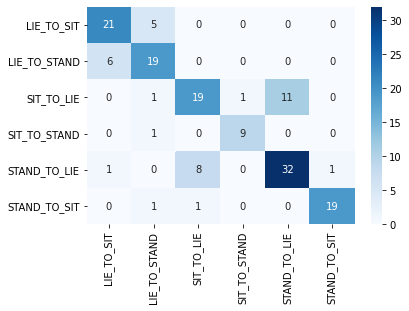

In [26]:
cf_matrix = confusion_matrix(y_test, y_pred)

categories = np.unique(y).tolist()
figsize = plt.rcParams.get('figure.figsize')
plt.figure(figsize=figsize)
sns.heatmap(cf_matrix, annot=True, fmt="", cmap='Blues', cbar=True, xticklabels=categories, yticklabels=categories)

## MLP with Oversampling

In [21]:
for i in range(1,11):
    mpl = MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 600,
                    hidden_layer_sizes=(i*50,),
                    random_state=42)

    steps = [SMOTE(random_state=42, n_jobs=-1), mpl]
    imba_pipeline = make_pipeline(*steps)

    result = cross_validate(imba_pipeline, X, y, cv=10, scoring=metrics, n_jobs=-1)

    print("Hidden Layers = " + str(mpl.hidden_layer_sizes[0]) + ":")

    print("\tf1:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_f1_weighted').mean()*100,
                std = result.get('test_f1_weighted').std()))

    print("\tROC AUC OneVsRest:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovr_weighted').mean()*100,
                std = result.get('test_roc_auc_ovr_weighted').std()))

    print("\tROC AUC OneVsOne:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovo_weighted').mean()*100,
                std = result.get('test_roc_auc_ovo_weighted').std()))

    print("\tbalanced accuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_balanced_accuracy').mean()*100,
                std = result.get('test_balanced_accuracy').std()))

    print("\taccuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
          .format(mean = result.get('test_accuracy').mean()*100,
                  std = result.get('test_accuracy').std()))

# best hidden layer size: 100

Hidden Layers = 50:
	f1:
		mean = 74.44%;
		std = 0.06;
	ROC AUC OneVsRest:
		mean = 94.59%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 95.44%;
		std = 0.02;
	balanced accuracy:
		mean = 77.70%;
		std = 0.06;
	accuracy:
		mean = 74.93%;
		std = 0.06;
Hidden Layers = 100:
	f1:
		mean = 75.02%;
		std = 0.07;
	ROC AUC OneVsRest:
		mean = 94.65%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 95.48%;
		std = 0.02;
	balanced accuracy:
		mean = 77.91%;
		std = 0.07;
	accuracy:
		mean = 75.51%;
		std = 0.07;
Hidden Layers = 150:
	f1:
		mean = 74.12%;
		std = 0.07;
	ROC AUC OneVsRest:
		mean = 94.67%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 95.50%;
		std = 0.02;
	balanced accuracy:
		mean = 76.77%;
		std = 0.07;
	accuracy:
		mean = 74.55%;
		std = 0.07;
Hidden Layers = 200:
	f1:
		mean = 73.91%;
		std = 0.06;
	ROC AUC OneVsRest:
		mean = 94.45%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 95.30%;
		std = 0.02;
	balanced accuracy:
		mean = 76.52%;
		std = 0.06;
	accuracy:
		mean = 74.35%;
		std = 0.0

In [24]:
for i in [75, 100, 125]:
    mpl = MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 600,
                    hidden_layer_sizes=(i,),
                    random_state=42)

    steps = [SMOTE(random_state=42, n_jobs=-1), mpl]
    imba_pipeline = make_pipeline(*steps)

    result = cross_validate(imba_pipeline, X, y, cv=10, scoring=metrics, n_jobs=-1)

    print("Hidden Layers = " + str(mpl.hidden_layer_sizes[0]) + ":")

    print("\tf1:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_f1_weighted').mean()*100,
                std = result.get('test_f1_weighted').std()))

    print("\tROC AUC OneVsRest:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovr_weighted').mean()*100,
                std = result.get('test_roc_auc_ovr_weighted').std()))

    print("\tROC AUC OneVsOne:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_roc_auc_ovo_weighted').mean()*100,
                std = result.get('test_roc_auc_ovo_weighted').std()))

    print("\tbalanced accuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_balanced_accuracy').mean()*100,
                std = result.get('test_balanced_accuracy').std()))

    print("\taccuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
          .format(mean = result.get('test_accuracy').mean()*100,
                  std = result.get('test_accuracy').std()))

Hidden Layers = 75:
	f1:
		mean = 74.43%;
		std = 0.07;
	ROC AUC OneVsRest:
		mean = 94.62%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 95.46%;
		std = 0.02;
	balanced accuracy:
		mean = 76.94%;
		std = 0.07;
	accuracy:
		mean = 74.93%;
		std = 0.07;
Hidden Layers = 100:
	f1:
		mean = 75.02%;
		std = 0.07;
	ROC AUC OneVsRest:
		mean = 94.65%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 95.48%;
		std = 0.02;
	balanced accuracy:
		mean = 77.91%;
		std = 0.07;
	accuracy:
		mean = 75.51%;
		std = 0.07;
Hidden Layers = 125:
	f1:
		mean = 73.67%;
		std = 0.07;
	ROC AUC OneVsRest:
		mean = 94.48%;
		std = 0.02;
	ROC AUC OneVsOne:
		mean = 95.32%;
		std = 0.02;
	balanced accuracy:
		mean = 76.33%;
		std = 0.07;
	accuracy:
		mean = 74.16%;
		std = 0.07;


## MLP with oversampling Report

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=42)
mpl = MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 600,
                    hidden_layer_sizes=(100,),
                    random_state=42)

steps = [SMOTE(random_state=42, n_jobs=-1), mpl]
imba_pipeline = make_pipeline(*steps)
imba_pipeline.fit(X_train, y_train)
y_pred = imba_pipeline.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

  LIE_TO_SIT       0.75      0.81      0.78        26
LIE_TO_STAND       0.73      0.76      0.75        25
  SIT_TO_LIE       0.72      0.66      0.69        32
SIT_TO_STAND       0.91      1.00      0.95        10
STAND_TO_LIE       0.79      0.79      0.79        42
STAND_TO_SIT       0.95      0.90      0.93        21

    accuracy                           0.79       156
   macro avg       0.81      0.82      0.81       156
weighted avg       0.79      0.79      0.79       156



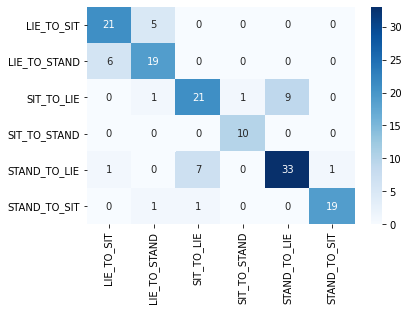

In [28]:
cf_matrix = confusion_matrix(y_test, y_pred)

categories = np.unique(y).tolist()
figsize = plt.rcParams.get('figure.figsize')
plt.figure(figsize=figsize)
sns.heatmap(cf_matrix, annot=True, fmt="", cmap='Blues', cbar=True, xticklabels=categories, yticklabels=categories)

In [3]:
metrics = [m for m in metrics if m not in ['roc_auc_ovr_weighted', 'roc_auc_ovo_weighted']]

## MLP with ADASYN Oversampling

In [4]:
for i in range(1,13):
    mpl = MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 600,
                    hidden_layer_sizes=(i*25,),
                    random_state=42)

    steps = [ADASYN(random_state=42, n_jobs=-1), mpl]
    imba_pipeline = make_pipeline(*steps)

    result = cross_validate(imba_pipeline, X, y, cv=10, scoring=metrics, n_jobs=-1)

    print("Hidden Layers = " + str(mpl.hidden_layer_sizes[0]) + ":")

    print("\tf1:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_f1_weighted').mean()*100,
                std = result.get('test_f1_weighted').std()))

    print("\tbalanced accuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_balanced_accuracy').mean()*100,
                std = result.get('test_balanced_accuracy').std()))

    print("\taccuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
          .format(mean = result.get('test_accuracy').mean()*100,
                  std = result.get('test_accuracy').std()))

# best hidden layer size: 50

Hidden Layers = 25:
	f1:
		mean = 73.09%;
		std = 0.07;
	balanced accuracy:
		mean = 76.35%;
		std = 0.06;
	accuracy:
		mean = 73.57%;
		std = 0.07;
Hidden Layers = 50:
	f1:
		mean = 74.30%;
		std = 0.06;
	balanced accuracy:
		mean = 77.91%;
		std = 0.05;
	accuracy:
		mean = 74.74%;
		std = 0.06;
Hidden Layers = 75:
	f1:
		mean = 73.57%;
		std = 0.07;
	balanced accuracy:
		mean = 76.37%;
		std = 0.06;
	accuracy:
		mean = 73.96%;
		std = 0.07;
Hidden Layers = 100:
	f1:
		mean = 73.55%;
		std = 0.07;
	balanced accuracy:
		mean = 76.31%;
		std = 0.07;
	accuracy:
		mean = 73.96%;
		std = 0.07;
Hidden Layers = 125:
	f1:
		mean = 73.64%;
		std = 0.07;
	balanced accuracy:
		mean = 76.51%;
		std = 0.07;
	accuracy:
		mean = 73.97%;
		std = 0.07;
Hidden Layers = 150:
	f1:
		mean = 73.79%;
		std = 0.07;
	balanced accuracy:
		mean = 76.84%;
		std = 0.07;
	accuracy:
		mean = 74.16%;
		std = 0.07;
Hidden Layers = 175:
	f1:
		mean = 73.67%;
		std = 0.07;
	balanced accuracy:
		mean = 76.51%;
		std = 0

## MLP with KMeansSMOTE Oversampling

In [5]:
for i in range(1,13):
    mpl = MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 600,
                    hidden_layer_sizes=(i*25,),
                    random_state=42)

    steps = [KMeansSMOTE(random_state=42, n_jobs=-1), mpl]
    imba_pipeline = make_pipeline(*steps)

    result = cross_validate(imba_pipeline, X, y, cv=10, scoring=metrics, n_jobs=-1)

    print("Hidden Layers = " + str(mpl.hidden_layer_sizes[0]) + ":")

    print("\tf1:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_f1_weighted').mean()*100,
                std = result.get('test_f1_weighted').std()))

    print("\tbalanced accuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_balanced_accuracy').mean()*100,
                std = result.get('test_balanced_accuracy').std()))

    print("\taccuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
          .format(mean = result.get('test_accuracy').mean()*100,
                  std = result.get('test_accuracy').std()))

# best hidden layer size: 50

Hidden Layers = 25:
	f1:
		mean = 74.12%;
		std = 0.05;
	balanced accuracy:
		mean = 77.55%;
		std = 0.05;
	accuracy:
		mean = 74.54%;
		std = 0.05;
Hidden Layers = 50:
	f1:
		mean = 74.49%;
		std = 0.06;
	balanced accuracy:
		mean = 77.64%;
		std = 0.07;
	accuracy:
		mean = 74.93%;
		std = 0.06;
Hidden Layers = 75:
	f1:
		mean = 74.45%;
		std = 0.06;
	balanced accuracy:
		mean = 77.45%;
		std = 0.06;
	accuracy:
		mean = 74.93%;
		std = 0.06;
Hidden Layers = 100:
	f1:
		mean = 74.23%;
		std = 0.06;
	balanced accuracy:
		mean = 77.13%;
		std = 0.06;
	accuracy:
		mean = 74.74%;
		std = 0.06;
Hidden Layers = 125:
	f1:
		mean = 74.12%;
		std = 0.07;
	balanced accuracy:
		mean = 76.83%;
		std = 0.07;
	accuracy:
		mean = 74.55%;
		std = 0.07;
Hidden Layers = 150:
	f1:
		mean = 73.70%;
		std = 0.07;
	balanced accuracy:
		mean = 76.52%;
		std = 0.07;
	accuracy:
		mean = 74.16%;
		std = 0.07;
Hidden Layers = 175:
	f1:
		mean = 73.97%;
		std = 0.08;
	balanced accuracy:
		mean = 76.66%;
		std = 0

## MLP with BorderlineSMOTE Oversampling

In [6]:
for i in range(1,13):
    mpl = MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 600,
                    hidden_layer_sizes=(i*25,),
                    random_state=42)

    steps = [BorderlineSMOTE(random_state=42, n_jobs=-1), mpl]
    imba_pipeline = make_pipeline(*steps)

    result = cross_validate(imba_pipeline, X, y, cv=10, scoring=metrics, n_jobs=-1)

    print("Hidden Layers = " + str(mpl.hidden_layer_sizes[0]) + ":")

    print("\tf1:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_f1_weighted').mean()*100,
                std = result.get('test_f1_weighted').std()))

    print("\tbalanced accuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
        .format(mean = result.get('test_balanced_accuracy').mean()*100,
                std = result.get('test_balanced_accuracy').std()))

    print("\taccuracy:")
    print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
          .format(mean = result.get('test_accuracy').mean()*100,
                  std = result.get('test_accuracy').std()))

# best hidden layer size: 125

Hidden Layers = 25:
	f1:
		mean = 74.73%;
		std = 0.06;
	balanced accuracy:
		mean = 78.08%;
		std = 0.05;
	accuracy:
		mean = 75.12%;
		std = 0.06;
Hidden Layers = 50:
	f1:
		mean = 75.00%;
		std = 0.07;
	balanced accuracy:
		mean = 78.68%;
		std = 0.06;
	accuracy:
		mean = 75.51%;
		std = 0.07;
Hidden Layers = 75:
	f1:
		mean = 75.08%;
		std = 0.07;
	balanced accuracy:
		mean = 78.44%;
		std = 0.06;
	accuracy:
		mean = 75.51%;
		std = 0.07;
Hidden Layers = 100:
	f1:
		mean = 74.01%;
		std = 0.07;
	balanced accuracy:
		mean = 77.42%;
		std = 0.07;
	accuracy:
		mean = 74.55%;
		std = 0.07;
Hidden Layers = 125:
	f1:
		mean = 75.72%;
		std = 0.07;
	balanced accuracy:
		mean = 78.95%;
		std = 0.06;
	accuracy:
		mean = 76.09%;
		std = 0.07;
Hidden Layers = 150:
	f1:
		mean = 74.32%;
		std = 0.07;
	balanced accuracy:
		mean = 77.79%;
		std = 0.06;
	accuracy:
		mean = 74.74%;
		std = 0.07;
Hidden Layers = 175:
	f1:
		mean = 73.81%;
		std = 0.07;
	balanced accuracy:
		mean = 76.92%;
		std = 0

## MLP with BorderlineSMOTE Report

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=42)
mpl = MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 600,
                    hidden_layer_sizes=(125,),
                    random_state=42)

steps = [BorderlineSMOTE(random_state=42, n_jobs=-1), mpl]
imba_pipeline = make_pipeline(*steps)
imba_pipeline.fit(X_train, y_train)
y_pred = imba_pipeline.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

  LIE_TO_SIT       0.75      0.81      0.78        26
LIE_TO_STAND       0.70      0.76      0.73        25
  SIT_TO_LIE       0.69      0.62      0.66        32
SIT_TO_STAND       0.90      0.90      0.90        10
STAND_TO_LIE       0.76      0.76      0.76        42
STAND_TO_SIT       0.95      0.90      0.93        21

    accuracy                           0.77       156
   macro avg       0.79      0.79      0.79       156
weighted avg       0.77      0.77      0.77       156



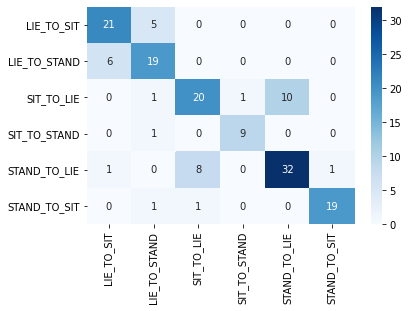

In [10]:
cf_matrix = confusion_matrix(y_test, y_pred)

categories = np.unique(y).tolist()
figsize = plt.rcParams.get('figure.figsize')
plt.figure(figsize=figsize)
sns.heatmap(cf_matrix, annot=True, fmt="", cmap='Blues', cbar=True, xticklabels=categories, yticklabels=categories)